In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env THEANO_FLAGS=warn_float64=warn

env: THEANO_FLAGS=warn_float64=warn


In [3]:
import dataset_generation

In [4]:
dataset_generation.SEQ_LEN = 120

In [5]:
import numpy as np
import theano
import theano.tensor as T
import lasagne
from theano import sparse
from lasagne.layers import *

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 630M (CNMeM is enabled with initial size: 80.0% of memory, cuDNN not available)


In [6]:
EMB_SIZE = 32

In [7]:
seq_len = theano.shared(dataset_generation.SEQ_LEN)

sequence = sparse.csc_fmatrix('input_seq')
dur_seq = T.fvector('Duration sequence')
d_s_resh = dur_seq.reshape((-1, seq_len))

embedd_w = theano.shared(np.random.normal(0,0.001, (128, EMB_SIZE)).astype("float32"))
sequence_embedded = sparse.dot(sequence, embedd_w).reshape((-1, seq_len, EMB_SIZE))



inputs = sequence_embedded[:,:-1]
dur_inps = d_s_resh[:,:-1]

targets = sequence.toarray().reshape((-1,seq_len,128))[:,1:]
dur_targets = d_s_resh[:, 1:]

l_input_sequence = InputLayer(shape=(None, None, EMB_SIZE),input_var=inputs)
l_input_dur_sequence = InputLayer(shape=(None, None),input_var=dur_inps)

In [8]:
from agentnet import Recurrence
from lasagne.layers import *
from agentnet.memory import *
from agentnet.resolver import ProbabilisticResolver

In [9]:
LSTM_SIZE = 100

In [10]:
from theano.tensor.shared_randomstreams import RandomStreams
srng = RandomStreams(seed=234)

In [11]:
def one_hot(t, r=None):
    """
    given a tensor t of dimension d with integer values from range(r), return a
    new tensor of dimension d + 1 with values 0/1, where the last dimension
    gives a one-hot representation of the values in t.

    if r is not given, r is set to max(t) + 1
    """
    if r is None:
        r = T.max(t) + 1

    ranges = T.shape_padleft(T.arange(r), t.ndim)
    return T.eq(ranges, T.shape_padright(t, 1))

def max_mask(t, axis):
    """
    given a tensor t and an axis, returns a mask tensor of the same size which is
    1 where the tensor has a maximum along the given axis, and 0 elsewhere.
    """
    a = T.argmax(t, axis=axis)
    a_oh = one_hot(a, t.shape[axis])
    # we want the 'one hot' dimension in the same position as the axis over
    # which we took the argmax. This takes some dimshuffle trickery:
    reordered_dims = range(axis) + [a_oh.ndim - 1] + range(axis, a_oh.ndim - 1)
    return a_oh.dimshuffle(reordered_dims)

In [12]:
###One step of rnn
class step:
    
    #inputs
    inp = InputLayer((None, EMB_SIZE),name='current embedded')
    dur_inp = InputLayer((None,),name='current dur')
    
    c_prev = InputLayer((None,LSTM_SIZE),name='previous rnn cell')
    h_prev = InputLayer((None,LSTM_SIZE),name='previous rnn state')
    
    c_new, h_new = LSTMCell(c_prev, h_prev,inp,name="LSTM") 
    
    next_token_probas = DenseLayer(h_new,128,nonlinearity=T.nnet.sigmoid)
    #next_token_probas = DenseLayer(next_token_probas,128,nonlinearity=T.nnet.sigmoid)
    
    next_token_probas_resh = ReshapeLayer(next_token_probas, (-1,128,1))
    
    next_token_probas = LSTMLayer(next_token_probas_resh,128,nonlinearity=T.nnet.sigmoid,cell_init=next_token_probas)
    
    next_token_probas = DenseLayer(next_token_probas, 1,num_leading_axes=2, nonlinearity=T.nnet.sigmoid)
    
    next_token_probas = ReshapeLayer(next_token_probas,(-1, 128))
    
    
    next_dur_ = DenseLayer(h_new,30,nonlinearity=T.nnet.sigmoid)
    next_dur_ = DenseLayer(next_dur_,1,nonlinearity=T.nnet.softplus)#softplus since durations are positive
    next_dur = ReshapeLayer(next_dur_, (-1,))
    
    def tokenize(probas):
        return T.lt(srng.uniform(size=probas.shape), probas ).astype('float32')#max_mask(probas, 1) for argmax
    
    #pick next token from predicted probas
    next_token = ExpressionLayer(next_token_probas, tokenize)
    next_emb = DenseLayer(next_token, EMB_SIZE, W=embedd_w)

In [13]:
training_loop = Recurrence(
    state_variables={step.h_new:step.h_prev, step.c_new:step.c_prev},
    input_sequences={step.inp:l_input_sequence, step.dur_inp:l_input_dur_sequence},
    tracked_outputs=[step.next_token_probas,step.next_dur],
    unroll_scan=False,force_cast_types=True
)

In [14]:

# Model weights
weights = lasagne.layers.get_all_params(training_loop,trainable=True)

weights+= [embedd_w]
print weights

[LSTM.b_to_ingate, LSTM.W_previous rnn state_to_ingate, LSTM.W_current embedded_to_ingate, LSTM.b_to_forgetgate, LSTM.W_previous rnn state_to_forgetgate, LSTM.W_current embedded_to_forgetgate, LSTM.b_to_cell, LSTM.W_previous rnn state_to_cell, LSTM.W_current embedded_to_cell, LSTM.b_to_outgate, LSTM.W_previous rnn state_to_outgate, LSTM.W_current embedded_to_outgate, LSTM.W_cell_to_ingate_peephole.scales, LSTM.W_cell_to_forgetgate_peephole.scales, LSTM.W_cell_to_outgate_peephole.scales, W, b, W_in_to_ingate, W_hid_to_ingate, b_ingate, W_in_to_forgetgate, W_hid_to_forgetgate, b_forgetgate, W_in_to_cell, W_hid_to_cell, b_cell, W_in_to_outgate, W_hid_to_outgate, b_outgate, W_cell_to_ingate, W_cell_to_forgetgate, W_cell_to_outgate, W, b, W, b, W, b, W]


In [15]:
predicted_probabilities = lasagne.layers.get_output(training_loop[step.next_token_probas])
predicted_durs = lasagne.layers.get_output(training_loop[step.next_dur])

In [16]:
SKIP_LOSS = theano.shared(20)

In [17]:
#iiinps = {sequence: notes.astype('float32'), dur_seq:durations.astype('float32')} #dbg

In [18]:
#loss_reg.eval(iiinps).shape

In [35]:
from collections import OrderedDict

logprobs = T.log(predicted_probabilities)
neglogprobs = T.log(1 - predicted_probabilities)
durs = predicted_durs.reshape((-1,seq_len - 1))

loss_categ = - targets* logprobs - (1-targets) * neglogprobs#binary crossentropy no need for 
loss_reg = lasagne.objectives.squared_error(dur_targets, durs)

loss = loss_categ.sum(axis=-1).reshape((-1,)) + loss_reg.reshape((-1,))
loss = loss.reshape((-1,seq_len - 1))[:,SKIP_LOSS:].mean()



updates = lasagne.updates.adagrad(loss,weights)

In [36]:
upds = OrderedDict()

In [37]:
for u in updates:
    upds[u] = updates[u].clip(-1,1)
    pass

In [38]:
#training
train_step = theano.function([sequence, dur_seq], [loss_categ, loss_reg],
                             updates=training_loop.get_automatic_updates()+upds, allow_input_downcast=True)

<<!! BUG IN FGRAPH.REPLACE OR A LISTENER !!>> <type 'exceptions.TypeError'> ('The type of the replacement must be compatible with the type of the original Variable.', Reshape{2}.0, Reshape{2}.0, TensorType(float32, row), TensorType(float32, matrix), 'local_reshape_dimshuffle') local_reshape_dimshuffle
ERROR (theano.gof.opt): Optimization failure due to: local_reshape_dimshuffle
ERROR (theano.gof.opt): node: Reshape{2}(InplaceDimShuffle{x,0}.0, <TensorType(int64, vector)>)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/usr/local/lib/python2.7/dist-packages/theano/gof/opt.py", line 2022, in process_node
    remove=remove)
  File "/usr/local/lib/python2.7/dist-packages/theano/gof/toolbox.py", line 391, in replace_all_validate_remove
    chk = fgraph.replace_all_validate(replacements, reason)
  File "/usr/local/lib/python2.7/dist-packages/theano/gof/toolbox.py", line 340, in replace_all_validate
    fgraph.replace(r, new_r, reason=rea

In [21]:
n_steps = T.scalar(dtype='int32')
feedback_loop = Recurrence(
    state_variables={step.h_new:step.h_prev, step.c_new:step.c_prev, 
                     step.next_emb:step.inp, step.next_dur:step.dur_inp},
    tracked_outputs=[step.next_token_probas,step.next_dur, step.next_token],
    batch_size=theano.shared(1),
    n_steps=n_steps,
    unroll_scan=False,
)

In [22]:
generated_tokens, generated_durs = get_output(feedback_loop[step.next_token, step.next_dur])

generated_music = T.stack([generated_tokens[0],generated_durs[0].reshape((-1,1))], axis=1)

In [23]:
generate_sample = theano.function([n_steps],[generated_tokens[0], generated_durs[0]],updates=feedback_loop.get_automatic_updates(),allow_input_downcast=True)

In [24]:
def gen_music(n_steps = dataset_generation.SEQ_LEN):
    tok, durss = generate_sample(n_steps)
    return np.hstack([tok,np.abs(durss.reshape((-1,1)))])

In [33]:
from midi_preproc import save_mat2_mid
save_mat2_mid(gen_music(500))

In [25]:
from tqdm import tqdm_notebook

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

In [27]:
categ_hist = []
reg_hist = []

In [28]:
dataset_generation.SEQ_LEN = 170
seq_len.set_value(dataset_generation.SEQ_LEN)

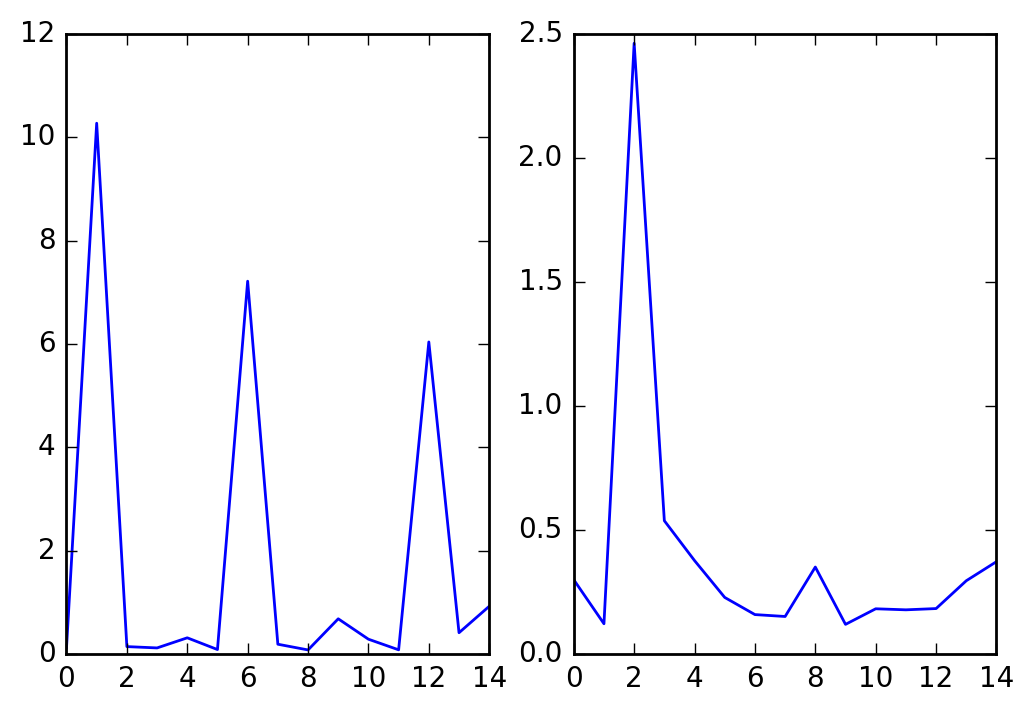

KeyboardInterrupt: 

In [39]:
from IPython.display import clear_output

batch_size = 5

#train loop
t = tqdm_notebook(dataset_generation.iterate_minibatches(1000, batch_size), total = 1000)



it = 1
for batch in t:
    notes = batch[:,:-1]
    durations = np.array( batch[:,-1].todense()).ravel()
    categ, reg = train_step(notes, durations)
    categ_hist.append(categ.mean())
    reg_hist.append(reg.mean())
    it+=1
    if it%1 == 0:
        clear_output()
        
        plt.subplot(1,2,1)
        plt.plot(categ_hist[-15:])
        plt.subplot(1,2,2)
        plt.plot(reg_hist[-15:])
        plt.show()

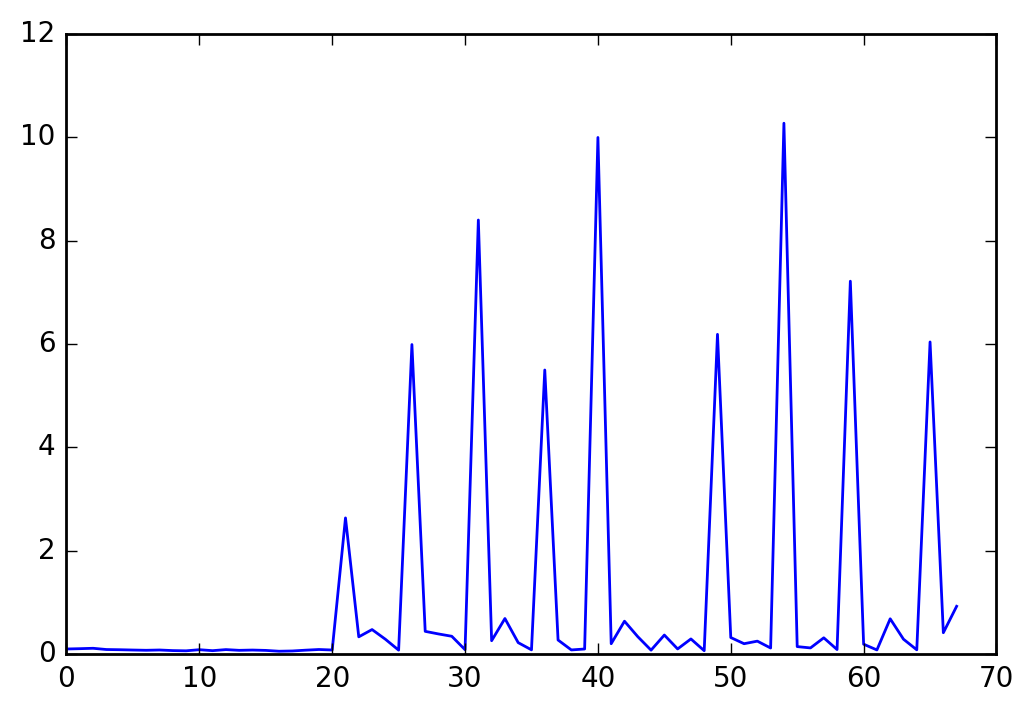

In [40]:
plt.plot(categ_hist)

In [29]:
import pickle as pkl

In [35]:
with open('params_lstmout.pkl','wb') as f:
    for w in weights:
        pkl.dump(w.get_value(), f)

In [30]:
with open('params_lstmout.pkl','rb') as f:
    for w in weights:
        w.set_value(pkl.load( f))